# Torch-dreams

This library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

<img src = "https://github.com/Mayukhdeb/torch-dreams/blob/master/images/banner_segmentation_model.png?raw=true">


## Quick start 

In [ ]:
!pip install torch-dreams  --upgrade
# !pip install git+https://github.com/Mayukhdeb/torch-dreams  ## for testing only 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams.dreamer import dreamer
import torchvision.models as models
plt.rcParams['figure.figsize'] = 5,5

## Minimal example

In [7]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model, device = 'cuda', quiet =  False)

In [8]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
)

100%|██████████| 120/120 [00:03<00:00, 32.83it/s]


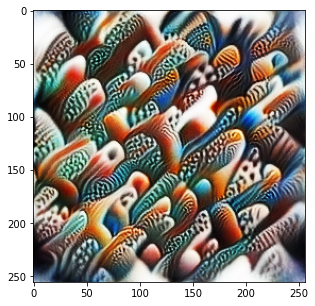

In [9]:
plt.imshow(image_param)
plt.show()

## Not so minimal looking example, but does the same thing as above



In [10]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
    width = 512,
    height = 256,
    iters = 150,
    lr = 9e-3,
    rotate_degrees = 15,
    scale_max = 1.2,
    scale_min =  0.5,
    translate_x = 0.2,
    translate_y = 0.2,
    custom_func = None,
    weight_decay = 1e-2,
    grad_clip = 1,
)

100%|██████████| 150/150 [00:04<00:00, 36.06it/s]


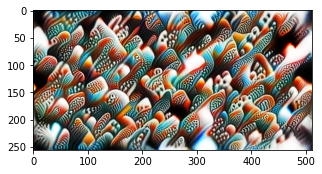

In [11]:
plt.imshow(image_param)
plt.show()

## Visualizing individual channels


We basically optimize the input image to maximize activations of a certain channel of a layer in the neural network.

The next step now would be to define a `custom_func` that would enable use to selectively optimize a single channel. We could've made a simpler function, but this would be useful when we'll be running the optimizations on a lot of channels

In [22]:
"""
feel free to use more layers for experiments 
"""
layers_to_use = [model.Mixed_6b.branch1x1.conv]

def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return -loss
    return custom_func

Now in order to optimize the **7th channel** of the **first layer** mentioned in `layers_to_use` we define the custom loss as:



In [13]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 119)

100%|██████████| 200/200 [00:06<00:00, 32.06it/s]


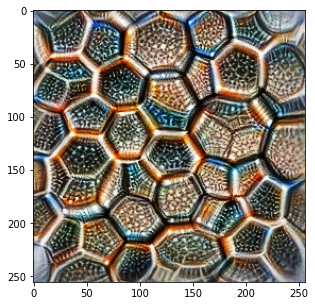

In [14]:
image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func = my_custom_func,
    iters = 200
)
plt.imshow(image_param)
plt.show()

## Using multiple models 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


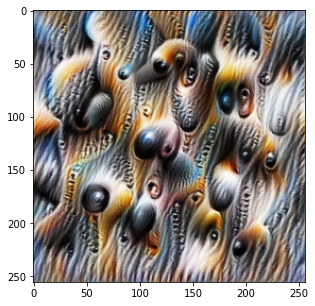

In [15]:
import matplotlib.pyplot as plt
import torchvision.models as models

from torch_dreams.dreamer import dreamer
from torch_dreams.model_bunch import ModelBunch

bunch = ModelBunch(
    model_dict = {
        'inception': models.inception_v3(pretrained=True).eval(),
        'resnet':    models.resnet18(pretrained= True).eval()
    }
)

layers_to_use = [
            bunch.model_dict['inception'].Mixed_6a,
            bunch.model_dict['resnet'].layer2[0].conv1
        ]

dreamy_boi = dreamer(model = bunch, quiet= True, device= 'cuda')

def custom_func(layer_outputs):
    loss =   layer_outputs[0].mean()*2.0 + layer_outputs[1][89].mean() 
    return -loss

image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func= custom_func,
    iters= 100
)

plt.imshow(image_param)
plt.show()

## Optimizing output channels of a segmentation model

In [27]:
segmentation_model = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()
dreamy_boi = dreamer(segmentation_model, quiet = True, device = 'cuda')
layers_to_use = [
    segmentation_model.aux_classifier[-1]
]

classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [28]:
from tqdm import tqdm

In [ ]:
all_outs = []
for i in tqdm(range(21)):
    my_func = make_custom_func(layer_number=0, channel_number= i)
    image_param = dreamy_boi.render(
        width = 256,
        height = 256,
        iters = 190,
        layers = layers_to_use,
        custom_func= my_func,
        lr = 8e-3,
        rotate_degrees = 25,
        scale_max= 1.2,
        scale_min= 0.2
    )
    all_outs.append(image_param)

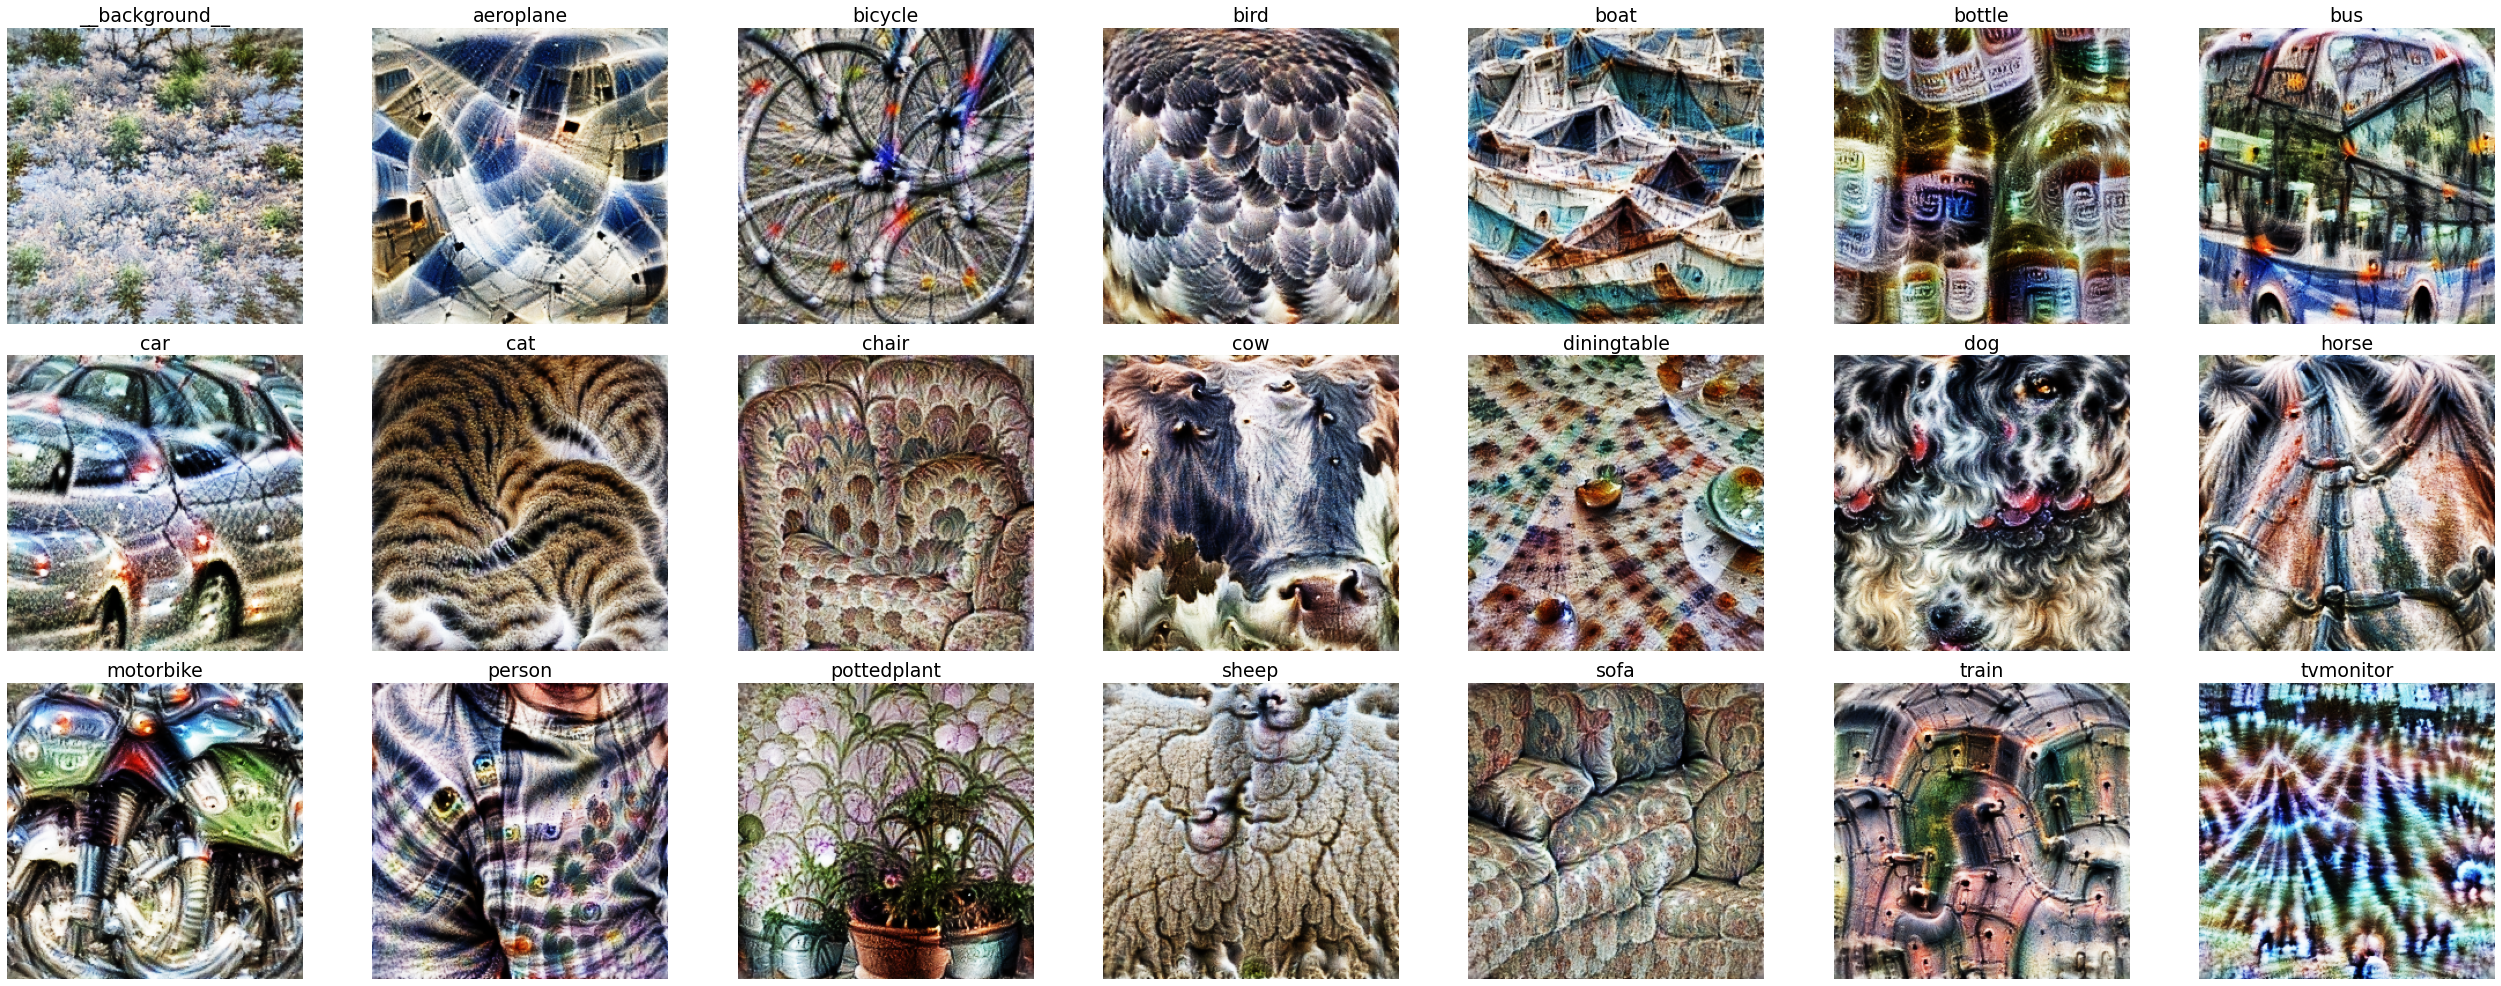

In [30]:
fig, ax = plt.subplots(nrows= 3, ncols= len(classes)//3, figsize=(18*2, 6*2.3))

for i in range(len(all_outs)):
    ax.flat[i].imshow(all_outs[i])
    ax.flat[i].set_title(classes[i], fontsize = 19)
    ax.flat[i].axis("off")
fig.tight_layout()

In [31]:
cherry_picked_indices = [6,15, 16, 14, 4, 13]
all_outs_cherry = []
dreamy_boi.quiet = True

for i in cherry_picked_indices:
    my_func = make_custom_func(layer_number=0, channel_number= i)
    image_param = dreamy_boi.render(
        width = 512,
        height = 256,
        iters = 250,
        layers = layers_to_use,
        custom_func= my_func,
        lr = 8e-3,
        rotate_degrees = 15,
        scale_max= 1.2,
        scale_min= 0.1,
        weight_decay = 1e-3
    )
    all_outs_cherry.append(image_param)

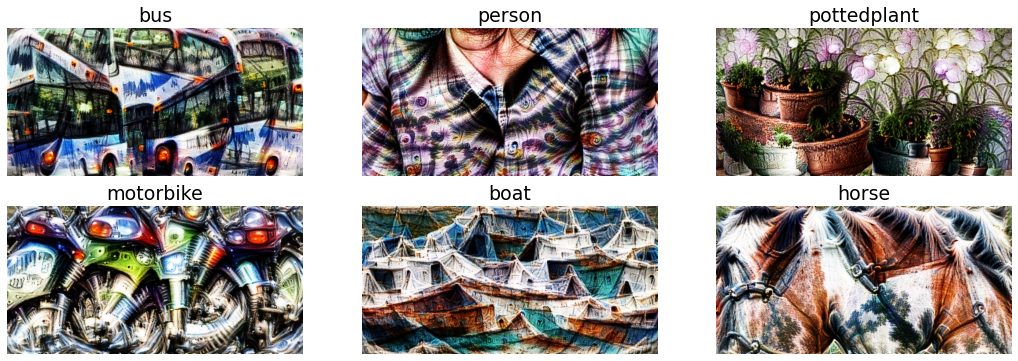

In [32]:
fig, ax = plt.subplots(nrows= 2, ncols= 3, figsize=(18, 6))

c = 0
for i in cherry_picked_indices:
    ax.flat[c].imshow(all_outs_cherry[c])
    ax.flat[c].set_title(classes[i], fontsize = 19)
    ax.flat[c].axis("off")
    c +=1 

In [45]:
import cv2
!mkdir images
c = 0
for i in cherry_picked_indices:
    filename = 'images/' + classes[i]+ '.jpg'
    all_outs_cherry[c].save(filename)
    print(filename)

images/bus.jpg
images/person.jpg
images/pottedplant.jpg
images/motorbike.jpg
images/boat.jpg
images/horse.jpg


## Let's combine features of a segmentation model and inception_v3 




In [4]:
from torch_dreams.model_bunch import ModelBunch

In [5]:
bunch = ModelBunch(
    model_dict = {
        'deeplab': models.segmentation.deeplabv3_resnet50(pretrained=True).eval(),
        'inception':  models.inception_v3(pretrained= True).eval(),
    }
)

layers_to_use = [
            bunch.model_dict['deeplab'].aux_classifier[-1],
            bunch.model_dict['inception'].Mixed_5b,
        ]

dreamy_boi = dreamer(model = bunch, quiet= False, device= 'cuda')


In [7]:
def custom_func(layer_outputs):
    loss =  layer_outputs[1].mean()*10  + layer_outputs[0][16].mean() *0.2
    return -loss


In [8]:
image_param = dreamy_boi.render(
    width = 512,
    height = 256,
    iters = 150,
    layers = layers_to_use,
    custom_func= custom_func,
    lr= 8e-3,
    rotate_degrees = 15,
    scale_max= 1.2,
    scale_min= 0.5,
    weight_decay = 1e-3
)

100%|██████████| 150/150 [00:13<00:00, 11.18it/s]


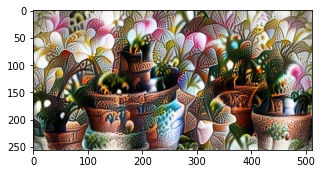

In [9]:
plt.imshow(image_param)
plt.show()

In [10]:
image_param.save('flower_plus_layer_texture.jpg')

## Applying custom masks 

In [11]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model,  device = 'cuda', quiet =  False)


In [12]:
import torchvision.transforms as transforms
import torch.nn as nn
import cv2
import torch
from torch_dreams.transforms import random_resize


class Mask(nn.Module):
    def __init__(self, mask_tensor, device = 'cuda'):
        super().__init__()
        self.mask_tensor = mask_tensor
        self.mask_tensor = self.mask_tensor.to(device)

    def forward(self,x):
        out = x * self.mask_tensor
        return out

### defining a mask

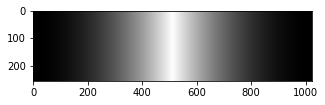

In [13]:
mask_np =1- np.abs(1- cv2.rotate(np.repeat(np.linspace(2, 0, 512),512*3).reshape(1024,256,3).astype(np.float32) ,cv2.ROTATE_90_CLOCKWISE))
mask_np = cv2.resize(mask_np, (1024, 256))
plt.imshow(mask_np**2)
plt.show()


### Setting  up custom transforms 

In [16]:
mask_tensor =  torch.tensor(mask_np).permute(-1,0,1).unsqueeze(0)

dreamy_boi.set_custom_transforms(
    transforms.Compose([
    Mask(mask_tensor = mask_tensor**2, device = dreamy_boi.device),  ## extra transform layer which multiplies the input image tensor by a mask
    transforms.RandomAffine(degrees = 15, translate= (0.2, 0.2)),
    random_resize(max_size_factor = 1.2, min_size_factor = 0.6),
    ])
)

In [17]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
    width = 1024,
    height = 256,
    iters = 150,
    weight_decay= 0.9
)


100%|██████████| 150/150 [00:05<00:00, 27.36it/s]


In [18]:
image_param.save('test_mask.jpg')

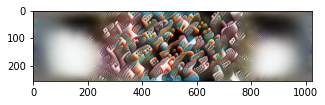

In [19]:
plt.imshow(image_param)
plt.show()

### Inverting the mask and optimizing another layer

In [20]:
dreamy_boi.set_custom_transforms(
    transforms.Compose([
    Mask(mask_tensor = (1. - mask_tensor**3), device = dreamy_boi.device),
    transforms.RandomAffine(degrees = 15, translate= (0.2, 0.2)),
    random_resize(max_size_factor = 1.2, min_size_factor = 0.6),
    ])
)

In [23]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 115)

image_param = dreamy_boi.render(
    image_parameter= image_param,
    layers = [model.Mixed_5d],
    iters = 40,
    lr = 0.06e-3,
    weight_decay= 1.7,
    grad_clip = 0.5,
    custom_func = None
)

100%|██████████| 40/40 [00:01<00:00, 24.31it/s]


In [24]:
image_param.save('test_mask_2.jpg')

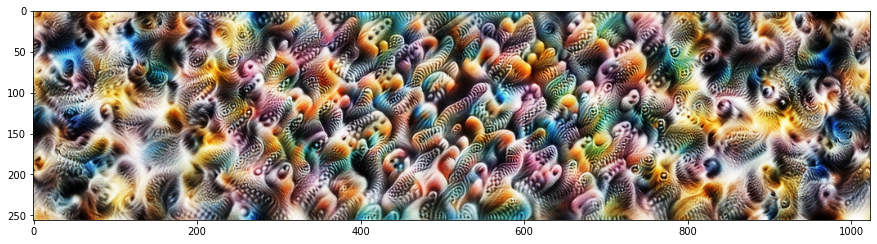

In [25]:
plt.rcParams['figure.figsize'] = 15, 15
plt.imshow(image_param)
plt.show()